In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from rational_functions import fit_polynomial, fit_rational_func
from gauss_freud_quad import get_nodes_and_weights
from scipy.optimize import brentq
from matplotlib import cm
import mgo

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

### Dispersion Relation

In [3]:
nu = 0
E = nu + 1/2
R = np.sqrt(2*E)

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return - x**2 - k**2 + 2*E

def get_k0(x0):
    return np.sqrt(np.round(2*E - x0**2, 4))

In [4]:
x0 = R
k0 = get_k0(x0)

In [5]:
from scipy.special import airy

def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

rho_ex = lambda x: (R**(2/3) * np.sqrt(R**2 - x**2)) / (2**(1/3) * x)
omega_bar_ex = lambda x: (x * np.sqrt(R**2-x**2) / 2
                          - R**2 * np.arccos(x/R)/2
                          + 2/3 * (rho_ex(x)**3)
                          + np.pi/4 * (1 - np.sign(x))
                          )

phi0 = (Ai(-(rho_ex(x0)**2)) * np.cos(omega_bar_ex(x0)) / np.sqrt(np.abs(x0))
                      - np.sign(x0) * Bi(-rho_ex(x0)**2) * np.sin(omega_bar_ex(x0)) / np.sqrt(np.abs(x0))
                      )

In [6]:
ND = 1
nt = 20000

xs = np.zeros((nt, ND))
ks = np.zeros((nt, ND))
omega0 = 1.0

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

sol = trace_ray_1D(x0=x0, k0=get_k0(x0), omega0=omega0, tmin=0, tmax=np.pi, D=D, x_max=(1-1e-3)*x0, tsteps=nt, rtol=1e-9)
sol_nt = len(sol.t)
xs[:sol_nt, :] = sol.y[:ND].T
ks[:sol_nt, :] = sol.y[ND:].T
min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
xs = xs[:min_nt, :]
ks = ks[:min_nt, :]
zs = np.concatenate([xs, ks], axis=-1)

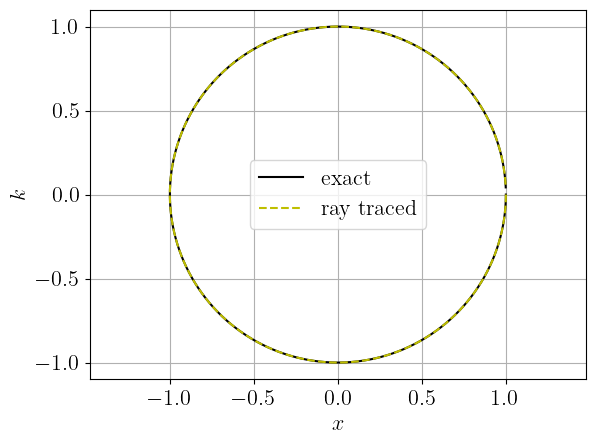

In [7]:
plt.axis('equal')
plt.plot(R*np.cos(2*t), -R*np.sin(2*t), 'k-', label='exact')
plt.plot(xs, ks, 'y--', label='ray traced')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$k$')
plt.legend()
plt.show()

In [8]:
# D_vec = np.vectorize(D)
# traced_D = D_vec(xs, ks, omega0*np.ones_like(xs))
# plt.plot(t, traced_D, label='$D(x(t), k(t), \omega)$')
# plt.ylim(-1e-5, 1e-5)
# plt.xlabel(r'$t$ [arb. u.]')
# plt.legend()
# plt.grid()

### Apply MGO

In [9]:
i_save = np.arange(0, nt, int(nt/16))

In [10]:
branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0=phi0, i_save=i_save, 
    analytic_cont={'phase': {'fit_func': fit_polynomial, 'kwargs': {'deg': 6, 'exclude_degrees': [1]}},
                   'amplitude': {'fit_func': fit_rational_func, 'kwargs': {'L': 4, 'M': 3, 'optimize': False}}})
results = mgo_info['saved_results']
Nt = mgo_info['Nt']
Upsilon = mgo_info['Upsilon']

In [11]:
field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=branch_masks, ray_field=ray_field)

#### Inspect Results

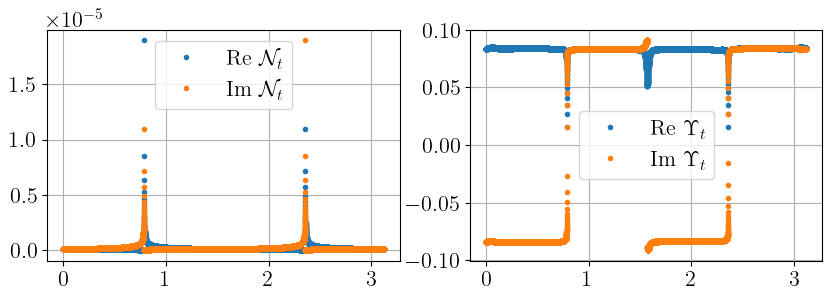

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(t, np.real(Nt), '.', label=r'Re $\mathcal{N}_t$')
ax[0].plot(t, np.imag(Nt), '.', label=r'Im $\mathcal{N}_t$')
ax[0].legend()
ax[0].grid()

ax[1].plot(t, np.real(Upsilon), '.', label=r'Re $\Upsilon_t$')
ax[1].plot(t, np.imag(Upsilon), '.', label=r'Im $\Upsilon_t$')
ax[1].legend()
ax[1].grid()

plt.show()

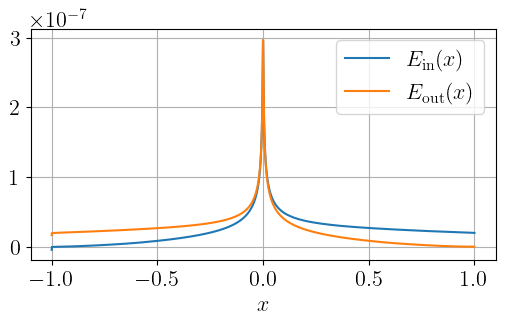

In [13]:
plt.figure(figsize=(6, 3))
plt.plot(xs[branch_masks[0], :], np.real(ray_field[branch_masks[0]]), '-', color='tab:blue', label='$E_\mathrm{in}(x)$')
plt.plot(xs[branch_masks[1], :], np.real(ray_field[branch_masks[1]]), '-', color='tab:orange', label='$E_\mathrm{out}(x)$')
plt.legend()
plt.xlabel(r'$x$')
plt.grid()
plt.show()

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


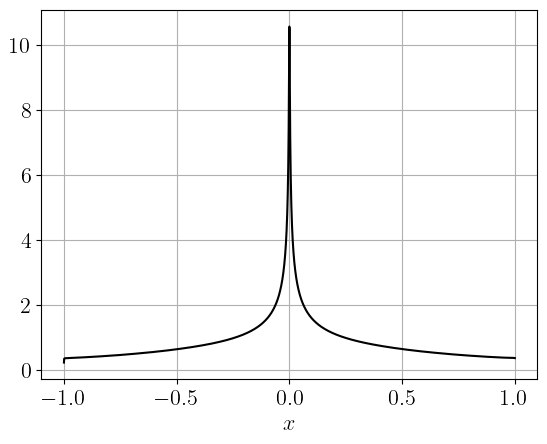

In [14]:
xi = np.linspace(np.min(xs), np.max(xs), 10000)
plt.plot(xi, field(xi), 'k-', label='$E(x)$')
# plt.ylim(0, 1)
plt.xlabel(r'$x$')
plt.grid()
plt.show()

#### Analytic Continuation

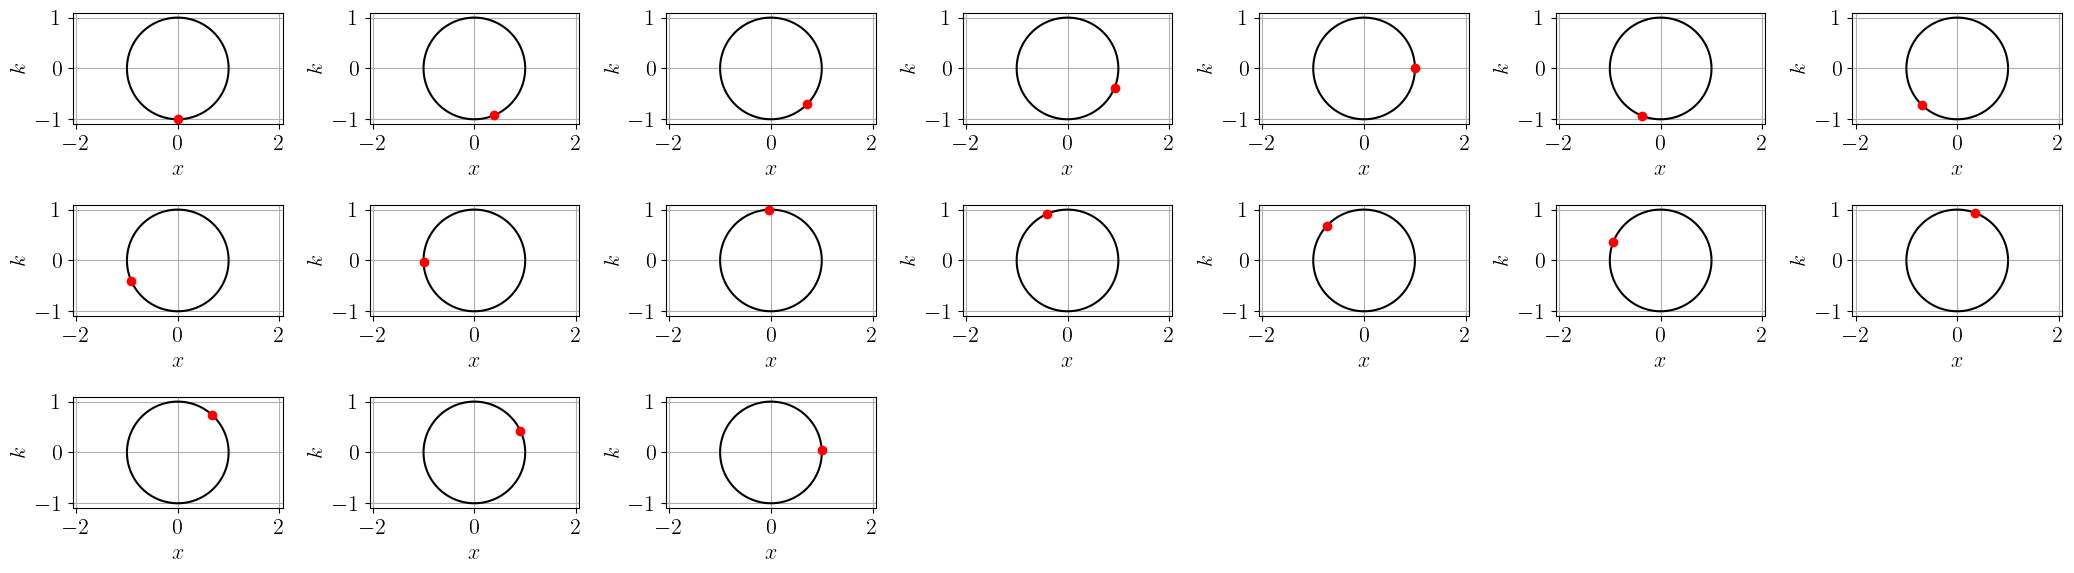

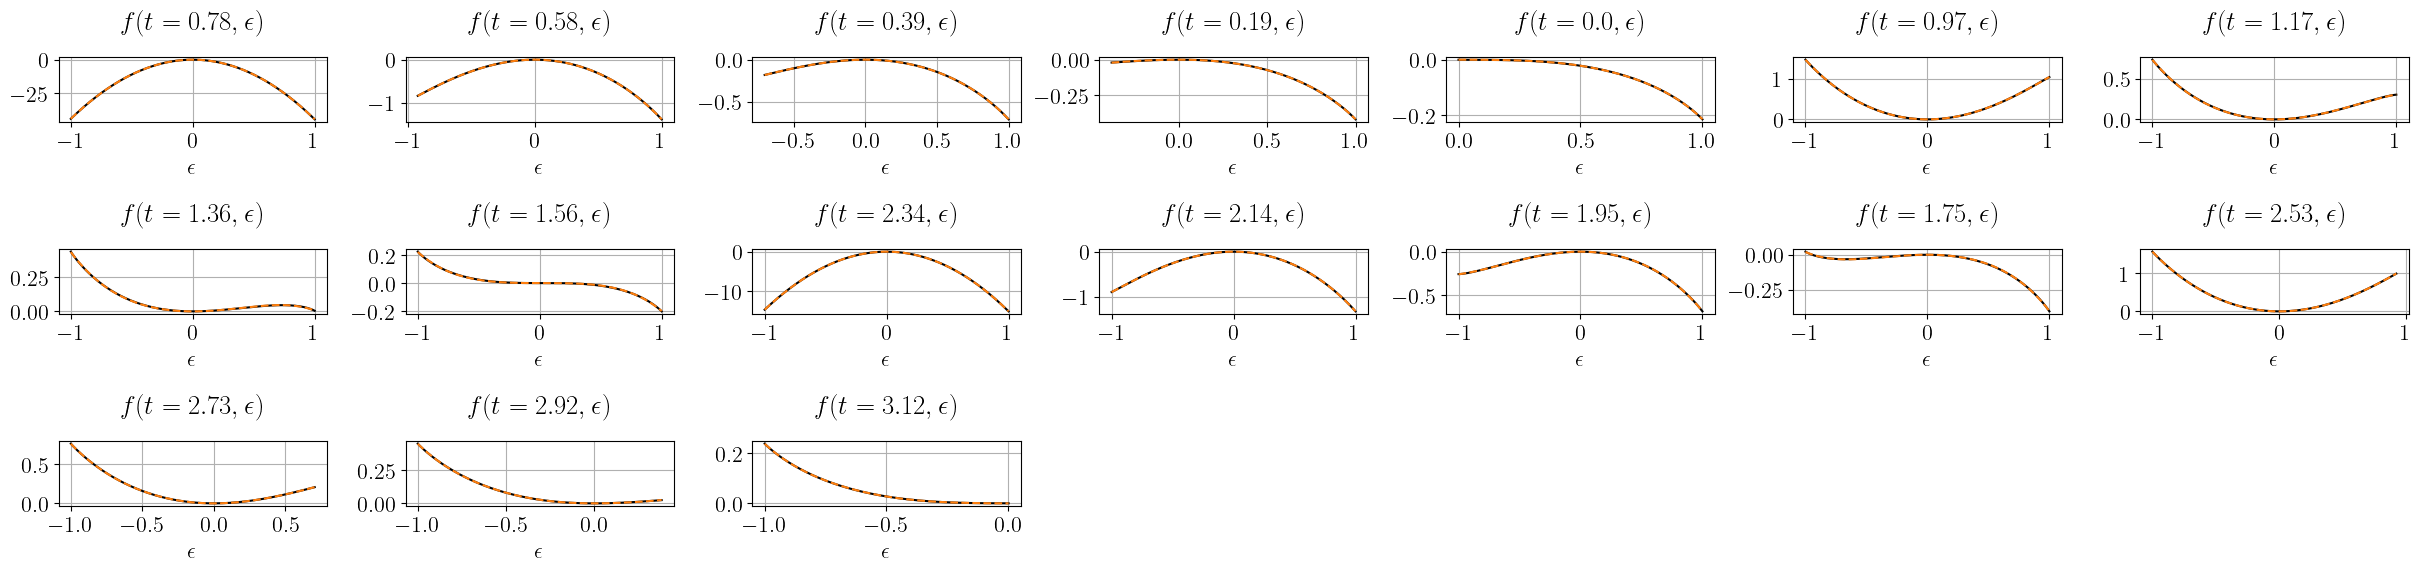

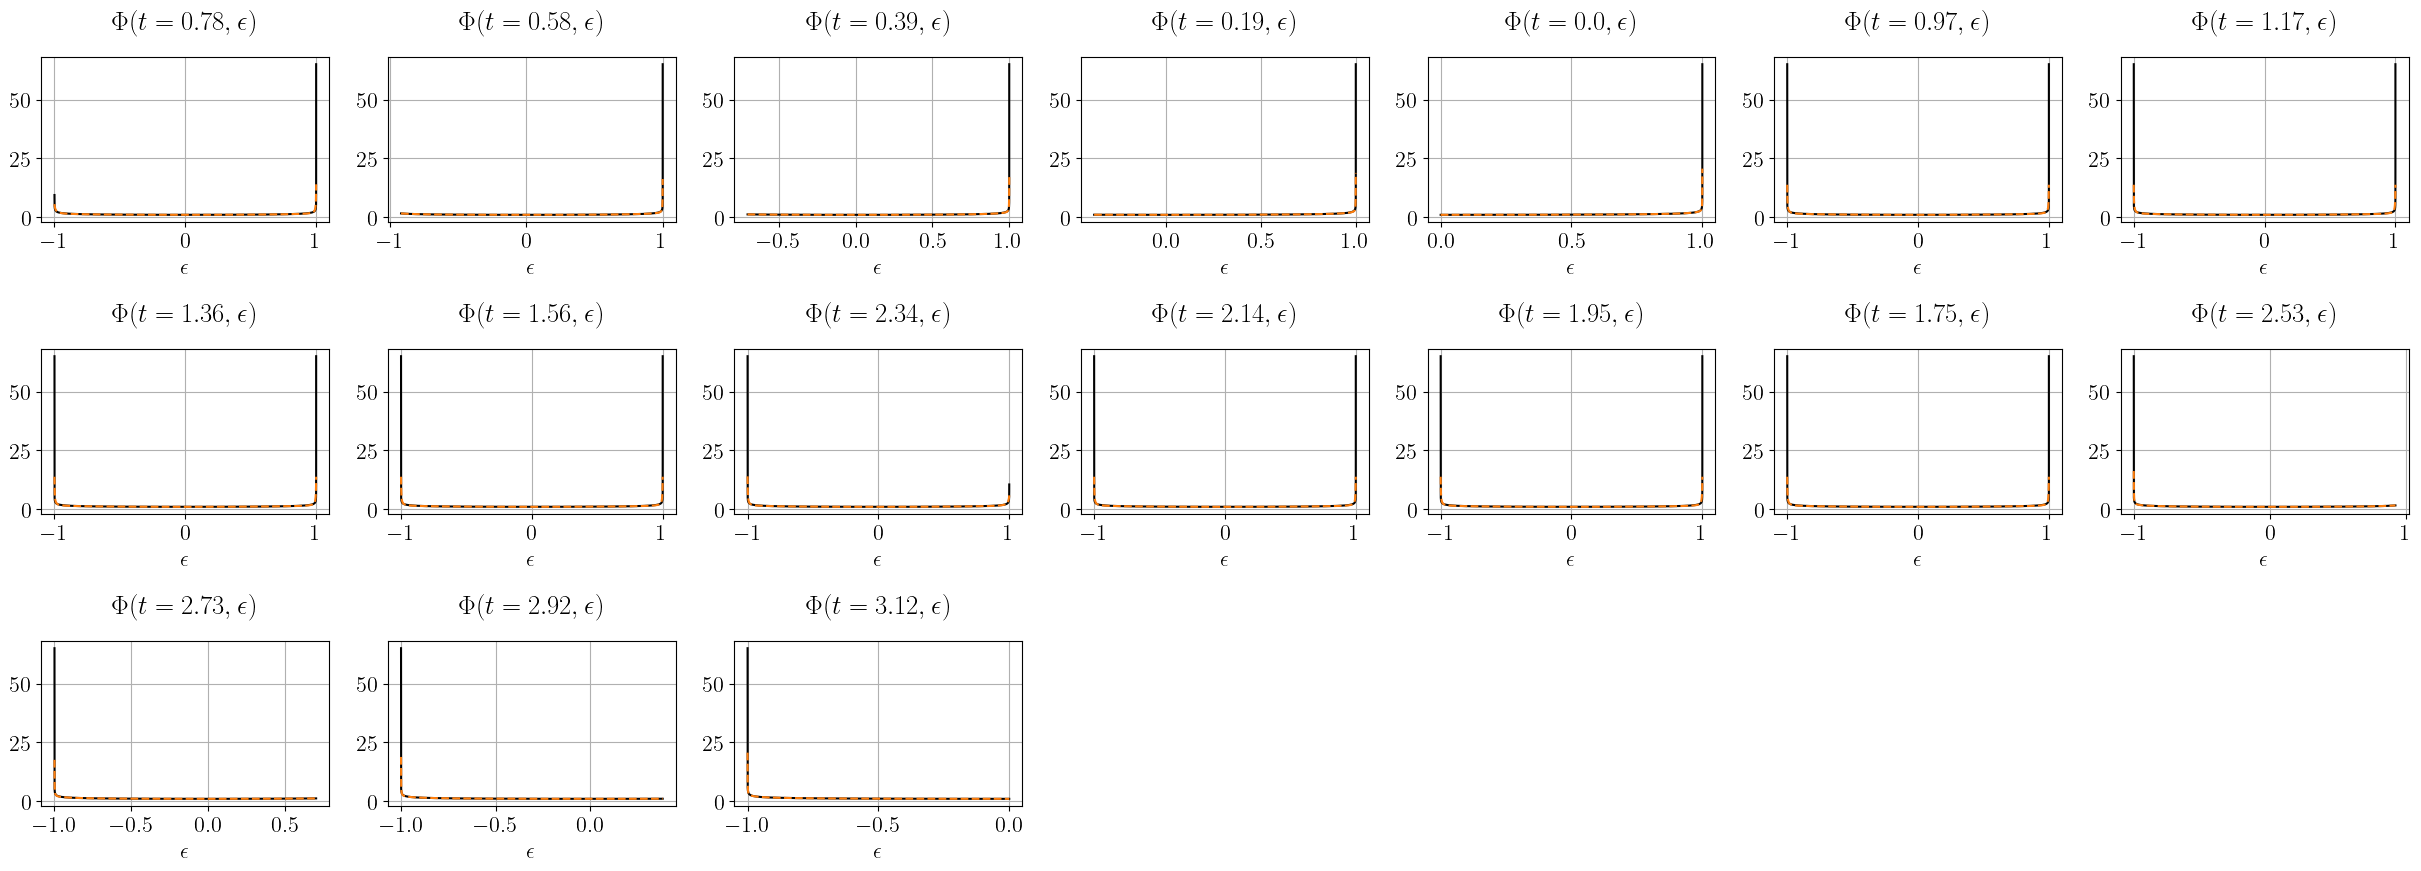

<Figure size 2450x900 with 0 Axes>

<Figure size 2450x900 with 0 Axes>

In [15]:
epsmax = np.round(np.mean([1/np.emath.sqrt(results[0]['s_m'][0]), 1/np.emath.sqrt(results[0]['s_p'][0])]), -3)
eps_R = np.linspace(-5*epsmax,5*epsmax, 1000)
eps_I = np.linspace(-5*epsmax,5*epsmax, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I
l_j, _ = get_nodes_and_weights(n=10)
l_j = l_j.astype(np.complex_)

ncols, nrows = 7, 3
fig = plt.figure(1, figsize=(ncols*3,nrows*2))
fig2 = plt.figure(2, figsize=(ncols*3.5,nrows*2))
fig3 = plt.figure(3, figsize=(ncols*3.5,nrows*3))
fig4 = plt.figure(4, figsize=(ncols*3.5,nrows*3))
fig5 = plt.figure(5, figsize=(ncols*3.5,nrows*3))
fig6 = plt.figure(5, figsize=(ncols*3.5,nrows*3))

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    t1, it, Xs_t1, Ks_t1, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'Xs_t1', 'Ks_t1', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    ax.axis('equal')
    ax.plot(xs.squeeze(), ks.squeeze(), 'k-')
    ax.plot(xs[it], ks[it], 'ro')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$k$')
    ax.grid()
fig.tight_layout()

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig2.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    k = ks[it, 0]
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, f_t1, 'k-')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='tab:orange')
    ax.set_title(r'$f(t = ' + str(np.round(t1,2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig2.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig2.add_subplot(nrows, ncols, 1 + i)
#     ax.axis('equal')
#     t1, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m = (result[key] for key in ['t1', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m'])
#     eps_rho = eps_rho.squeeze()
#     contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
#     fig.colorbar(contour_plot, ax=ax)
#     ax.set_title(r'$f(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + r'$ ns$, \epsilon)$')
#     # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
#     # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

#     # Plot node points along integral path
#     ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
#     ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
# fig2.tight_layout()

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig3.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, Phi_t1, 'k-')
    ax.plot(eps_rho, g_fit(eps_rho), '--', color='tab:orange')
    ax.set_title(r'$\Phi(t = ' + str(np.round(t1, 2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig3.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig4.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     ax.plot(eps_rho, fd.grad(f_t1, eps_rho), 'k-')
#     ax.plot(eps_rho, f_fit.deriv(axis=0, order=1)(eps_rho), '--', color='tab:orange')
#     ax.set_title(r"$f'(t = " + str(np.round((t1 - t[i_caust])*1e9,2)) + r"$ ns$, \epsilon)$")
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig4.tight_layout()


# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig5.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, Theta_t1, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     k = ks[it, 0]
#     ax.plot(eps_rho, Theta_t1, 'k-')
#     ax.set_title(r'$\Theta(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + r'$ ns$, \epsilon)$')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig5.tight_layout()

# plt.show()

#### Exact Solution

In [16]:
from util import continuous_sqrt_of_reals

In [17]:
xs_ex = lambda t: R * np.cos(2*t)
ks_ex = lambda t: - R * np.sin(2*t)
A_ex = lambda t: -np.sin(2*t)
B_ex = lambda t: -np.cos(2*t)
B_phase = lambda t: np.pi * np.floor((4*t-np.pi)/(2*np.pi))
sigma_t_ex = lambda t: np.exp(-1j * np.pi * np.floor((4*t+np.pi)/(4*np.pi)))
# Nt_ex = lambda t: sigma_t_ex(t) * (np.exp(1j*t*(R**2) - 1j * ((R**2)/4) * np.sin(4*t))
#                     / (
#                         np.emath.sqrt(-1j*2*np.pi*2*R)
#                         * np.sqrt(np.abs(B_ex(t)))
#                         * np.exp(1j*B_phase(t)/2)
#                     ))
Nt_ex = lambda t: (np.exp(1j*t*(R**2) - 1j * ((R**2)/4) * np.sin(4*t))
                    / (
                        np.emath.sqrt(-1j*2*np.pi*2*R)
                        * continuous_sqrt_of_reals(B_ex(t))
                    ))

s = lambda t: -np.sign(np.tan(2*t))
Upsilon_ex = lambda t: ( np.pi * ((2*R)**(1/3))
                            * np.exp(-1j * (R**2)/3 * ((np.tan(2*t))**3) )
                            * (
                                Ai(-(np.tan(2*t)**2)/4 * ((2*R)**(4/3)))
                                + 1j * s(t) *
                                Bi(-(np.tan(2*t)**2)/4 * ((2*R)**(4/3)))
                            )
                            )

rho_ex = lambda x: (R**(2/3) * np.sqrt(R**2 - x**2)) / (2**(1/3) * x)
omega_bar_ex = lambda x: (x * np.sqrt(R**2-x**2) / 2
                          - R**2 * np.arccos(x/R)/2
                          + 2/3 * (rho_ex(x)**3)
                          + np.pi/4 * (1 - np.sign(x))
                          )
field_ex = lambda x: (Ai(-(rho_ex(x)**2)) * np.cos(omega_bar_ex(x)) / np.sqrt(np.abs(x))
                      - np.sign(x) * Bi(-rho_ex(x)**2) * np.sin(omega_bar_ex(x)) / np.sqrt(np.abs(x))
                      )

In [18]:
t_ex = np.linspace(-np.pi/2, np.pi/2, 1000)

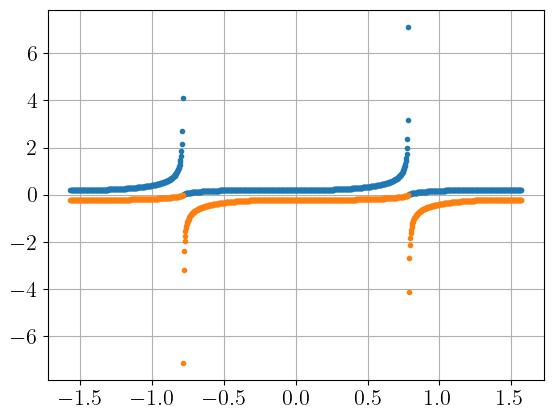

In [19]:
plt.plot(t_ex, np.real(Nt_ex(t_ex)), '.')
plt.plot(t_ex, np.imag(Nt_ex(t_ex)), '.')
plt.grid()
plt.show()

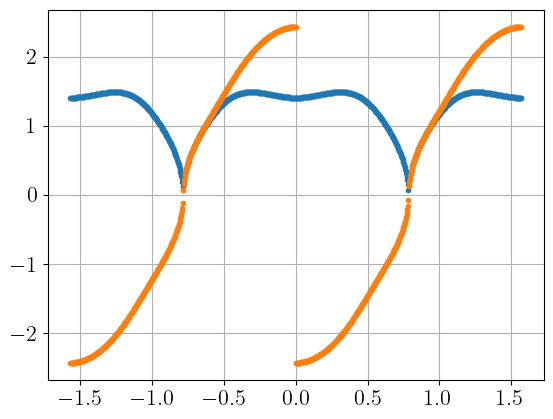

In [20]:
plt.plot(t_ex, np.real(Upsilon_ex(t_ex)), '.')
plt.plot(t_ex, np.imag(Upsilon_ex(t_ex)), '.')
plt.grid()
plt.show()

In [21]:
phi0 = field_ex(xs_ex(t_ex))[0]
A0 = phi0/(Nt_ex(t_ex)[0]*Upsilon_ex(t_ex)[0] + Nt_ex(t_ex)[-1]*Upsilon_ex(t_ex)[-1] )

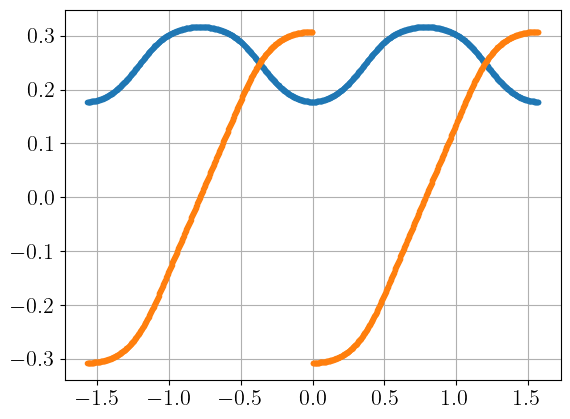

In [22]:
plt.plot(t_ex, np.real(A0*Nt_ex(t_ex)*Upsilon_ex(t_ex)), '.')
plt.plot(t_ex, np.imag(A0*Nt_ex(t_ex)*Upsilon_ex(t_ex)), '.')
plt.grid()
plt.show()

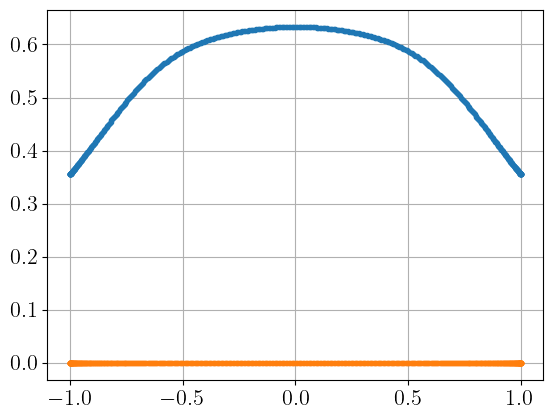

In [23]:
plt.plot(xs_ex(t_ex[t_ex < 0]), np.real(A0 * (  Nt_ex(t_ex[t_ex < 0])*Upsilon_ex(t_ex[t_ex < 0])
                        + (Nt_ex(t_ex[t_ex >= 0])*Upsilon_ex(t_ex[t_ex >= 0]))[::-1] )), '.')
plt.plot(xs_ex(t_ex[t_ex < 0]), np.imag(A0 * (  Nt_ex(t_ex[t_ex < 0])*Upsilon_ex(t_ex[t_ex < 0])
                        + (Nt_ex(t_ex[t_ex >= 0])*Upsilon_ex(t_ex[t_ex >= 0]))[::-1] )), '.')
plt.grid()
plt.show()

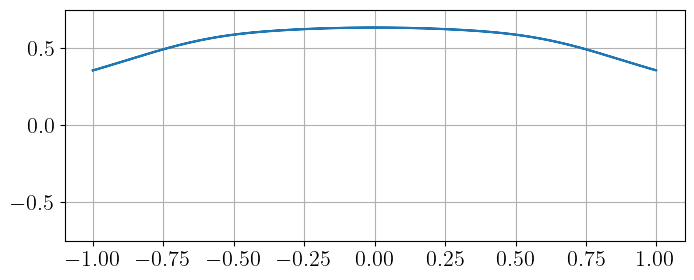

In [24]:
plt.figure(figsize=(8,3))
plt.plot(xs_ex(t_ex), field_ex(xs_ex(t_ex)), '-')
# plt.plot(t_ex, np.imag(Nt_ex(t_ex)), '.')
plt.ylim(-0.75, 0.75)
plt.grid()
plt.show()

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


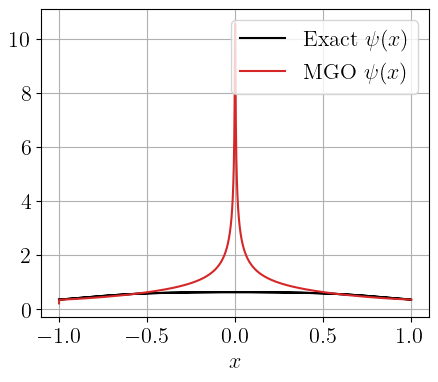

In [53]:
plt.figure(figsize=(5,4))
xi = np.linspace(np.min(xs), np.max(xs), 10000)
plt.plot(xs_ex(t_ex), field_ex(xs_ex(t_ex)), 'k-', label='Exact $\psi(x)$')
plt.plot(xi, field(xi), '-', color='tab:red', label='MGO $\psi(x)$')
# plt.ylim(0, 1)
plt.legend()
plt.xlabel(r'$x$')
plt.grid()
plt.savefig('./plots/MGO_weber_field_nu_' + str(nu) + '.png')
plt.savefig('./plots/MGO_weber_field_nu_' + str(nu) + '.pdf')
plt.show()

#### Old Stuff

In [26]:
# def get_phase(z, branch_cut_dir=np.pi):
#     phase = np.angle(z) % (2*np.pi)
#     phase = (phase - branch_cut_dir) % (2*np.pi) + branch_cut_dir
#     return phase

# def sqrt_with_branch_cut(z, branch_cut_dir=np.pi, phase=None):
#     amplitude = np.abs(z)
#     if phase is None:
#         phase = get_phase(z, branch_cut_dir=branch_cut_dir)
#     return np.sqrt(amplitude)*np.exp(1j*(phase)/2)

In [27]:
# plt.plot(t, np.imag(- 1j * 2*np.pi * 2*R * B_ex(t)))
# plt.plot(t, np.angle(- 1j * 2*np.pi * 2*R * B_ex(t)))
# plt.plot(t, np.real(np.emath.sqrt(- 1j * 2*np.pi * 2*R * B_ex(t))), 'g--', linewidth=6)
# plt.plot(t, np.imag(np.emath.sqrt(- 1j * 2*np.pi * 2*R * B_ex(t))), 'r:', linewidth=6)
# plt.plot(t, np.real(sqrt_with_branch_cut(- 1j * 2*np.pi * 2*R * B_ex(t), branch_cut_dir=-np.pi)), 'k-')
# plt.plot(t, np.imag(sqrt_with_branch_cut(- 1j * 2*np.pi * 2*R * B_ex(t), branch_cut_dir=-np.pi)), 'y--')
# plt.grid()

In [28]:
# sqrt_phase = lambda t: -np.pi/2 + B_phase(t)
# # Nt_ex = lambda t: sigma_t_ex(t) * (np.exp(1j*t*(R**2) - 1j * ((R**2)/4) * np.sin(4*t))
# #                  / (
# #                      sqrt_with_branch_cut(- 1j * 2*np.pi * 2*R * B_ex(t), branch_cut_dir=0, phase=sqrt_phase(t))
# #                  ))
# Nt_ex = lambda t: sigma_t_ex(t) * (np.exp(1j*t*(R**2) - 1j * ((R**2)/4) * np.sin(4*t))
#                  / (
#                      sqrt_with_branch_cut(- 1j * 2*np.pi * 2*R * B_ex(t), branch_cut_dir=-np.pi)
#                     #  np.emath.sqrt(- 1j * 2*np.pi * 2*R * B_ex(t))
#                  ))

In [29]:
# plt.plot(t, B_phase(t))
# plt.plot(t, np.angle(B_ex(t)))
# plt.plot(t, get_phase(B_ex(t), branch_cut_dir=np.pi/2), '--')

In [30]:
# plt.plot(t, np.imag(sigma_t_ex(t)))
# plt.plot(t, np.real(sigma_t_ex(t)))

In [31]:
# plt.plot(t, np.imag(sigma_t_ex(t) / sqrt_with_branch_cut(B_ex(t), branch_cut_dir=np.pi/2)), '.')
# plt.plot(t, np.real(sigma_t_ex(t) / sqrt_with_branch_cut(B_ex(t), branch_cut_dir=np.pi/2)), '.')

In [32]:
# plt.plot(t, np.real(Nt_ex(t)), '.')
# plt.plot(t, np.imag(Nt_ex(t)), '.')

In [33]:
# thetas = np.linspace(-6*np.pi, 6*np.pi, 1000)
# z_vals = np.exp(1j*thetas)

# # # plt.figure(figsize=(10,10))
# # plt.plot(thetas, np.real(np.emath.sqrt(z_vals)), 'k-')
# # plt.plot(thetas, np.imag(np.emath.sqrt(z_vals)), 'r-')
# # plt.plot(thetas, np.real(sqrt_with_branch_cut(z_vals, branch_cut_dir=np.pi/2)), 'y--')
# # plt.plot(thetas, np.imag(sqrt_with_branch_cut(z_vals, branch_cut_dir=np.pi/2)), 'c--')
# plt.plot(thetas, np.angle(z_vals))
# plt.plot(thetas, get_phase(z_vals, branch_cut_dir=0), 'c--')
# # plt.plot(thetas, get_phase(z_vals, branch_cut_dir=np.pi/2), 'c--')
# # plt.plot(thetas, get_phase(z_vals, branch_cut_dir=np.pi), 'c--')
# # plt.plot(thetas, get_phase(z_vals, branch_cut_dir=3*np.pi/2), 'c--')
# plt.plot(thetas, get_phase(z_vals, branch_cut_dir=7*np.pi/2) % (2*np.pi), 'r:')

# plt.xticks(np.arange(-6, 7)*np.pi, labels=[r'$' + str(i) + r'\pi$' for i in np.arange(-6, 7)], rotation=90)
# # plt.yticks(np.arange(-2, 3)*np.pi, labels=[r'$' + str(i) + r'\pi$' for i in np.arange(-2, 3)])
# plt.grid()
# plt.show()

In [34]:
# for i in range(10):
#     branch_cut_dir = 2*np.pi*i/10
#     print(np.round(np.sum(z_vals - sqrt_with_branch_cut(z_vals, branch_cut_dir=branch_cut_dir)**2), 12))
#     print(np.round(np.sum(z_vals - np.abs(z_vals)*np.exp(1j*get_phase(z_vals, branch_cut_dir=branch_cut_dir))), 12))

In [35]:
# %matplotlib qt

In [36]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# z1 = np.linspace(-1, 1)
# z2 = np.linspace(-1, 1)
# Z1, Z2 = np.meshgrid(z1, z2)

# # Plot the surface.
# branch_cut_dir = np.pi/2
# ax.set_title(r'arg $z$ with branch cut in dir: ' + str(branch_cut_dir/np.pi) + r'$\pi$')
# surf = ax.plot_surface(Z1, Z2, get_phase(Z1+1j*Z2, branch_cut_dir=-np.pi), cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.set_xlabel(r'Re $z$')
# ax.set_ylabel(r'Im $z$')
# # ax.view_init(90, 0, 90)

# fig.show()

In [37]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# z1 = np.linspace(-1, 1)
# z2 = np.linspace(-1, 1)
# Z1, Z2 = np.meshgrid(z1, z2)

# # Plot the surface.
# branch_cut_dir = np.pi/2
# ax.set_title(r'Re $z^{1/2}$ with branch cut in dir: ' + str(branch_cut_dir/np.pi) + r'$\pi$')
# surf = ax.plot_surface(Z1, Z2, np.real(sqrt_with_branch_cut(Z1+1j*Z2, branch_cut_dir=branch_cut_dir)), cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.set_xlabel(r'Re $z$')
# ax.set_ylabel(r'Im $z$')
# # ax.view_init(90, 0, 90)
# fig.show()

In [38]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# z1 = np.linspace(-1, 1)
# z2 = np.linspace(-1, 1)
# Z1, Z2 = np.meshgrid(z1, z2)

# # Plot the surface.
# ax.set_title(r'Im $z^{1/2}$ with branch cut in dir: ' + str(branch_cut_dir/np.pi) + r'$\pi$')
# surf = ax.plot_surface(Z1, Z2, np.imag(sqrt_with_branch_cut(Z1+1j*Z2, branch_cut_dir=branch_cut_dir)), cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.set_xlabel(r'Re $z$')
# ax.set_ylabel(r'Im $z$')
# # ax.view_init(90, 0, 90)
# fig.show()

In [39]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# z1 = np.linspace(-1, 1)
# z2 = np.linspace(-1, 1)
# Z1, Z2 = np.meshgrid(z1, z2)

# # Plot the surface.
# ax.set_title(r'Re np.emath.sqrt($z$)')
# surf = ax.plot_surface(Z1, Z2, np.real(np.emath.sqrt(Z1+1j*Z2)), cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.set_xlabel(r'Re $z$')
# ax.set_ylabel(r'Im $z$')
# # ax.view_init(90, 0, 90)
# fig.show()

In [40]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# z1 = np.linspace(-1, 1)
# z2 = np.linspace(-1, 1)
# Z1, Z2 = np.meshgrid(z1, z2)

# # Plot the surface.
# ax.set_title(r'Im np.emath.sqrt($z$)')
# surf = ax.plot_surface(Z1, Z2, np.imag(np.emath.sqrt(Z1+1j*Z2)), cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.set_xlabel(r'Re $z$')
# ax.set_ylabel(r'Im $z$')
# # ax.view_init(90, 0, 90)
# fig.show()

In [41]:
# %matplotlib inline

In [42]:
# plt.plot(thetas, np.real(z_vals - np.emath.sqrt(z_vals)**2))
# plt.plot(thetas, np.imag(z_vals - np.emath.sqrt(z_vals)**2))
# plt.ylim(-1,1)

In [43]:
# plt.plot(thetas, np.real(z_vals - sqrt_with_branch_cut(z_vals, branch_cut_dir=0)**2))
# plt.plot(thetas, np.imag(z_vals - sqrt_with_branch_cut(z_vals, branch_cut_dir=0)**2))
# plt.ylim(-1,1)

In [44]:
# plt.plot(t, np.real(Nt_ex(t)))
# plt.plot(t, np.imag(Nt_ex(t)))
# plt.grid()

In [45]:
# plt.plot(t, np.real(Upsilon_approx(t)))
# # plt.plot(t, np.imag(Upsilon_approx(t)))
# plt.grid()

In [46]:
# plt.plot(t, np.real(Nt_ex(t)*Upsilon_approx(t)))
# plt.grid()
# # plt.plot(t, np.imag(Nt_ex(t)*Upsilon_approx(t)))

In [47]:

# sgn_B = np.exp(1j * np.pi* np.floor((4*t-np.pi)/(2*np.pi)))
# sqrt_sgn_B = np.exp(1j * np.pi/2 * np.floor((4*t-np.pi)/(2*np.pi)))
# plt.plot(t, -np.cos(2*t), 'k-')
# plt.plot(t, B_ex(t), 'y--')
# plt.plot(t, np.real(np.abs(B_ex(t))*sgn_B), 'r--')
# plt.plot(t, np.imag(np.abs(B_ex(t))*sgn_B), 'g--')
# plt.plot(t, sgn_B, color='tab:blue')
# plt.plot(t, sigma_t_ex(t), color='tab:orange')
# # # plt.plot(t, np.real(np.emath.sqrt(B_ex(t))), 'k-')
# # # plt.plot(t, np.imag(np.emath.sqrt(B_ex(t))), 'k--')
# # # plt.plot(t, np.real(np.emath.sqrt(np.abs(B_ex(t))*sgn_B)), 'k-')
# # # plt.plot(t, np.imag(np.emath.sqrt(np.abs(B_ex(t))*sgn_B)), 'k--')
# # # plt.plot(t, np.real(np.sqrt(np.abs(B_ex(t)))*sqrt_sgn_B), 'k-')
# # # plt.plot(t, np.imag(np.sqrt(np.abs(B_ex(t)))*sqrt_sgn_B), 'k--')
# # plt.plot(t, np.real(  sigma_t_ex(t)/( np.sqrt(np.abs(B_ex(t)))*sqrt_sgn_B )  ), 'k-')
# # plt.plot(t, np.imag(  sigma_t_ex(t)/( np.sqrt(np.abs(B_ex(t)))*sqrt_sgn_B )  ), 'k--')
# # plt.plot(t, np.abs(  sigma_t_ex(t)/( np.sqrt(np.abs(B_ex(t)))*sqrt_sgn_B )  ), 'g-')
# plt.grid()

In [48]:
# # plt.plot(t, Nt)
# plt.plot(t, np.real(Nt_ex(t)))
# plt.plot(t, np.imag(Nt_ex(t)), '--')
# plt.plot(t, np.abs(Nt_ex(t)), 'g-')
# plt.grid()